<a href="https://www.kaggle.com/code/ibrahimnibrahim/mental-health-glove-6b-200d?scriptVersionId=244286490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [2]:
data=pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
import nltk
from nltk.corpus import stopwords

text=data['statement'].apply(lambda x: str(x).split())
labels=data['status']

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

text=text.apply(lambda x : ' '.join([word for word in x if word not in stop_words]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=0.2, random_state=101)

In [5]:
import tensorflow as tf

vectorized_layer=tf.keras.layers.TextVectorization(ragged=True,max_tokens=10000)
vectorized_layer.adapt(text_train)

In [6]:
train_sequence=vectorized_layer(text_train)
test_sequence=vectorized_layer(text_test)

train_padded=tf.keras.utils.pad_sequences(
    train_sequence.numpy(),
    maxlen=50,
    padding='pre',
    truncating='pre',
)
test_padded=tf.keras.utils.pad_sequences(
    test_sequence.numpy(),
    maxlen=50,
    padding='pre',
    truncating='pre',
)

In [7]:
label_vectorizer=tf.keras.layers.StringLookup(num_oov_indices=0)
label_vectorizer.adapt(labels_train)

In [8]:
labels_train=label_vectorizer(labels_train)
labels_test=label_vectorizer(labels_test)

In [9]:
train_padded=tf.data.Dataset.from_tensor_slices(train_padded)
test_padded=tf.data.Dataset.from_tensor_slices(test_padded)

labels_train=tf.data.Dataset.from_tensor_slices(labels_train)
labels_test=tf.data.Dataset.from_tensor_slices(labels_test)

train_dataset=tf.data.Dataset.zip(train_padded,labels_train)
test_dataset=tf.data.Dataset.zip(test_padded,labels_test)

In [10]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE).batch(64)
test_dataset=test_dataset.cache().prefetch(tf.data.AUTOTUNE).batch(64)

In [11]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-06-07 22:41:18--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-07 22:41:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.73MB/s    in 3m 29s  

2025-06-07 22:44:49 (3.94 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [12]:
# Define path to file containing the embeddings
glove_file = 'glove.6B.200d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [13]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((10000, 200))
word_index = {x:i for i,x in enumerate(vectorized_layer.get_vocabulary())}
# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [14]:
model = tf.keras.Sequential([
   tf.keras.layers.Input(shape=(50,)),  # Input layer
   tf.keras.layers.Embedding(input_dim=10000, output_dim=embeddings_matrix.shape[1]
                             , weights=[embeddings_matrix], trainable=False),  # Embedding layer
    # tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 50)              │          45,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 30)              │           7,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         384,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,439,946 (9.31 MB)

 Trainable params: 439,946 (1.68 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [16]:
es=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

In [17]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset,callbacks=[es,])

Epoch 1/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.5863 - loss: 1.0964 - val_accuracy: 0.6883 - val_loss: 0.7880
Epoch 2/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7095 - loss: 0.7455 - val_accuracy: 0.7202 - val_loss: 0.7247
Epoch 3/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7394 - loss: 0.6710 - val_accuracy: 0.7322 - val_loss: 0.6998
Epoch 4/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7625 - loss: 0.6116 - val_accuracy: 0.7219 - val_loss: 0.7180
Epoch 5/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7797 - loss: 0.5573 - val_accuracy: 0.7349 - val_loss: 0.7199
Epoch 6/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7930 - loss: 0.5196 - val_accuracy: 0.7222 - val_loss: 0.7462
Epoch 7/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8203 - loss: 0.4559 - val_accuracy: 0.7318 - val_loss: 0.7818
Epoch 8/30
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8479 - loss: 0.3871 - val_acc

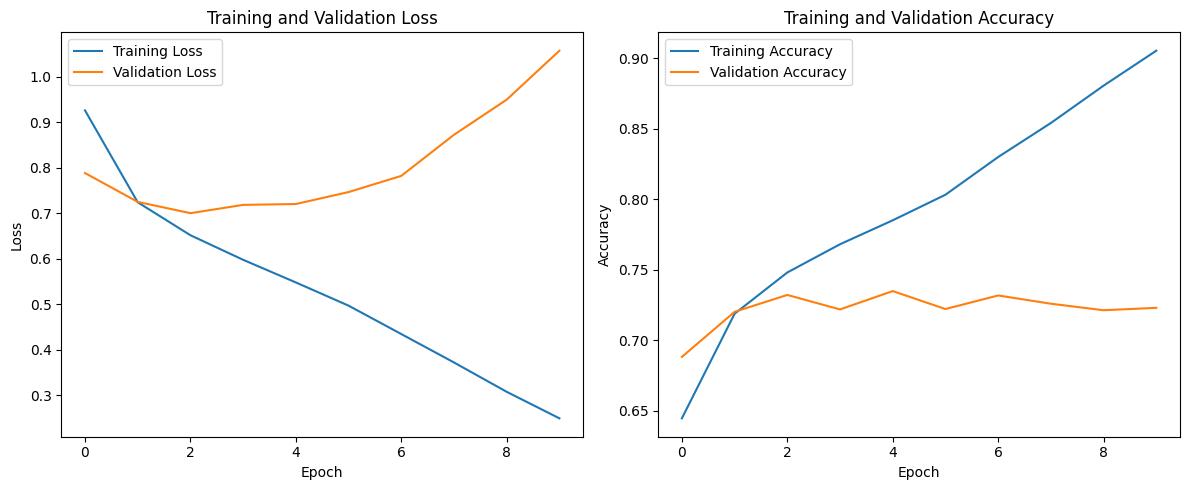

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()